In [1]:
# imports
import os
os.sys.path.append(os.path.abspath("../.."))

import pandas as pd
import numpy as np

from project.model.ssd_model_300_xception import ssd_model_300_xception
from project.model.ssd_model_300_resnet import ssd_model_300_resnet
from project.model.ssd_model_300_vgg import ssd_model_300_vgg

from project.utils.data_bbox_match_hdf5 import load_ohc

from IPython.display import display

import h5py

from tqdm import tqdm, trange

from keras.preprocessing import image

import project.download_content as content

from project.notebooks_utils import visuals
from matplotlib import pyplot as plt

from project.model.iou import iou

METAPATH = os.path.join(content.DATAPATH, 'METADATA')
MODELPATH = os.path.join(content.DATAPATH, 'MODEL')
ohc = load_ohc()

Using TensorFlow backend.
/home/bruno/.virtualenvs/ml/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/bruno/.virtualenvs/ml/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
ohc.get_feature_names()[592]

'x0_woman'

### Getting data

In [3]:
cross_val_preprocessed = os.path.join(content.DATAPATH,
                                      "MODEL",
                                      f"cross_val_data_preprocessed.h5")

test_preprocessed = os.path.join(content.DATAPATH,
                                     "MODEL",
                                     f"test_data_preprocessed.h5")

In [4]:
df = pd.read_hdf(cross_val_preprocessed, key='X', mode='r')
df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic,cx,cy,w,h,LabelID
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964201,0.071038,0.800546,0,0,0,0,0,project/data/VALIDATION/validation/0001eeaf4ae...,airplane,0.493437,0.435792,0.941527,0.729508,4
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0,project/data/VALIDATION/validation/000595fe6fe...,food,0.500000,0.500000,1.000000,1.000000,199
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0,project/data/VALIDATION/validation/000595fe6fe...,fruit,0.160530,0.703991,0.038292,0.055432,210
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0,project/data/VALIDATION/validation/000595fe6fe...,fruit,0.233432,0.327051,0.039764,0.055432,210
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0,project/data/VALIDATION/validation/000595fe6fe...,fruit,0.260677,0.517738,0.055965,0.055432,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303975,ffff21932da3ed01,xclick,/m/03fp41,1,0.178125,0.710938,0.412500,0.579167,0,0,1,0,0,project/data/VALIDATION/validation/ffff21932da...,houseplant,0.444531,0.495833,0.532813,0.166667,258
303976,ffff21932da3ed01,xclick,/m/01g317,1,0.000000,0.015625,0.345833,0.414583,0,1,0,1,0,project/data/VALIDATION/validation/ffff21932da...,person,0.007812,0.380208,0.015625,0.068750,380
303977,ffff21932da3ed01,xclick,/m/01g317,1,0.062500,0.085938,0.431250,0.529167,1,0,0,0,0,project/data/VALIDATION/validation/ffff21932da...,person,0.074219,0.480208,0.023438,0.097917,380
303978,ffff21932da3ed01,xclick,/m/0c9ph5,1,0.323437,0.409375,0.464583,0.554167,0,0,1,0,0,project/data/VALIDATION/validation/ffff21932da...,flower,0.366406,0.509375,0.085938,0.089583,195


In [5]:
model = ssd_model_300_resnet(inference=True)

model.load_weights(os.path.abspath(content.DATAPATH) + '/resnet-weights300.h5')

display(model.summary())

# turn on the engine =]
model.predict(images[:1]);

/home/bruno/projetos/capstone-udacity-mle/project/model/ssd_model_300_resnet.py:84: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

None

NameError: name 'images' is not defined

### FINAL

In [ ]:
%%time
from sklearn.metrics import auc

total = {}

def images(label_id):
    images = []

    with h5py.File(os.path.join(MODELPATH, 'cross_val', f'{label_id}.h5'), mode='r') as f:
        images_ids = list(f.keys())
        for k in images_ids:
            images.append(f[k][:])
        
    return np.concatenate(images, axis=0), images_ids

def match_predictions(label_id, predictions, image_ids):
    results = []

    for img_id, img_pred in zip(image_ids, predictions):
        ground_truths = df[(df.ImageID == img_id)
                           & (df.LabelID == label_id)][['cx', 'cy', 'w', 'h']].values
        bboxes_preds = np.pad(img_pred[img_pred[..., 0] == label_id],
                              [[0, 0],[0, 1]])

        if bboxes_preds.shape[0] > 0:
            for bbox_label in ground_truths:
                ious = iou(bbox_label, bboxes_preds[..., -5:-1])
                index = np.argmax(ious)

                if ious[index] >= .5:
                    bboxes_preds[index, -1] = 1

        results.append(bboxes_preds)
        
    return np.concatenate(results)

def calc_auc(label_id, total_bbox, matched):
    true_positives = matched[matched[..., -1] == 1][..., 1]
    false_positives = matched[matched[..., -1] == 0][..., 1]
    
    if true_positives.shape[0] == 0:
        return 0
    
    percs = [np.percentile(true_positives, i) for i in range(0, 100, 3)]
    
    precisions = []
    recalls = []

    for perc in percs:
        if matched[matched[:, 1] > perc].shape[0] > 0:
            precision = (true_positives[true_positives > perc].shape[0]
                         / matched[matched[:, 1] > perc].shape[0])
        else:
            precision = 0

        recall = (true_positives[true_positives > perc].shape[0]
                  / total_bbox)

        precisions.append(precision)
        recalls.append(recall)

    # ordering recall and replicate to precisions
    sort_p, sort_r = zip(*sorted(zip(precisions, recalls),
                                 key=lambda x: x[1]))
    
    return auc(sort_r, sort_p)

    
def eval_category(label_id):
    label = ohc.get_feature_names()[label_id-1][3:]
    
#     print(f'loading images of class {label}...')
    imgs, img_ids = images(label_id)
    
#     print(f'starting prediction for class {label}...')
    preds = model.predict(imgs)
    
#     print(f'evaluating bouding boxes...')
    matched = match_predictions(label_id, preds, img_ids)
    
    total_bbox = df[df.LabelID == label_id].shape[0]
    
#     print(f'calculating AP metric for class {label}...')
    
    return label, calc_auc(label_id, total_bbox, matched)
    
for i in trange(0, 600):
    try:
        ap = eval_category(i)
        total[ap[0]] = ap[1]
        if ap[1] > 0:
            print(i, ap)
    except OSError:
        pass


  1%|          | 5/600 [01:18<3:35:30, 21.73s/it]

4 ('airplane', 0.18366062778408246)


  2%|▏         | 9/600 [01:40<1:49:12, 11.09s/it]

8 ('animal', 0.0009894196743806295)


  3%|▎         | 19/600 [03:40<3:54:04, 24.17s/it]

18 ('baked_goods', 0.2125448090629551)


  8%|▊         | 51/600 [06:39<2:34:11, 16.85s/it]

50 ('bird', 0.005672752034865907)


  9%|▉         | 54/600 [07:27<3:01:09, 19.91s/it]

53 ('boat', 0.009781162877047622)


  9%|▉         | 56/600 [07:34<2:16:28, 15.05s/it]

55 ('book', 0.0007442384004884005)


 11%|█         | 65/600 [09:04<2:39:06, 17.84s/it]

64 ('boy', 0.04325186040182922)


 12%|█▏        | 72/600 [12:07<7:04:30, 48.24s/it]

71 ('building', 0.15050866854743067)


 12%|█▎        | 75/600 [12:20<2:51:49, 19.64s/it]

74 ('bus', 0.2682956890044296)


 13%|█▎        | 80/600 [13:03<1:54:28, 13.21s/it]

79 ('cake', 0.1267110141896173)


 14%|█▍        | 84/600 [13:17<1:00:33,  7.04s/it]

83 ('camera', 0.08689177257001399)


 15%|█▌        | 92/600 [20:24<17:28:46, 123.87s/it]

91 ('car', 0.13185824423673317)


 16%|█▌        | 97/600 [20:56<3:25:15, 24.48s/it]  

96 ('castle', 0.1405054405054405)


 16%|█▋        | 98/600 [21:24<3:32:55, 25.45s/it]

97 ('cat', 0.32615269628562077)


 20%|█▉        | 117/600 [31:14<21:14:33, 158.33s/it]

116 ('clothing', 0.003257603723591844)


 20%|██        | 123/600 [31:56<4:31:12, 34.11s/it]  

122 ('coffee_cup', 0.08957423432260486)


 22%|██▏       | 132/600 [32:27<44:35,  5.72s/it]  

131 ('convenience_store', 0.023138297872340424)


 26%|██▌       | 155/600 [35:01<2:42:25, 21.90s/it]

154 ('dessert', 0.2035939652784164)


 26%|██▋       | 159/600 [35:06<1:02:19,  8.48s/it]

158 ('dinosaur', 0.1011033681765389)


 27%|██▋       | 161/600 [37:10<5:04:21, 41.60s/it]

160 ('dog', 0.2587906136404432)


 28%|██▊       | 165/600 [37:37<2:00:25, 16.61s/it]

164 ('door', 0.0056642082669356485)


 31%|███       | 185/600 [39:47<15:12,  2.20s/it]  

In [257]:
total

{'accordion': 0,
 'adhesive_tape': 0,
 'aircraft': 0,
 'airplane': 0.18366062778408246}

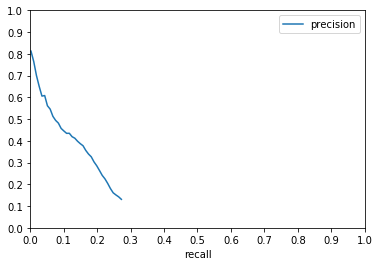

In [213]:
arr.plot.line(x='recall', y='precision',
             yticks=np.arange(0, 1.1, .1),
             xticks=np.arange(0, 1.1, .1))